# Histone coverage plots

First, all modules are imported and functions are defined:

In [1]:
import pyteomics
import pyteomics.fasta
import csv
import numpy as np 
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors

def getProteinsModsAndCoverage(
    enzyme_file_names,
    fasta_file_name,
    mascot_file_delimiter=",",
#   description_format=lambda x: x.split()[0][3:]
    description_format=lambda x: x.split()[0].split("|")[-1]
):
    # fasta  format: "sp|P15507|NPMB_BOVIN Morphine-modulating neuropeptide B OS=Bos taurus OX=9913 PE=1 SV=1"
    # mascot format: "P15507|NPMB_BOVIN"
    protein_sequences = {description_format(description): sequence for description, sequence in pyteomics.fasta.read(fasta_file_name)}
    mods = {enzyme: ["Unmodified"] for enzyme in enzyme_file_names.keys()}
    peptides = {enzyme: [] for enzyme in enzyme_file_names.keys()}
    coverage = {}
    for enzyme, file_name in enzyme_file_names.items():
        with open(file_name, "r") as raw_file:
            csv_file = csv.reader(raw_file, delimiter=mascot_file_delimiter)
            for row in csv_file:
                if (len(row) > 0) and (row[0] == "Identifier"):
                    break
            while True:
                try:
                    identifier, ptm_name, *tmp = next(csv_file)
                    if identifier == "":
                        raise ValueError
                    mods[enzyme].append(ptm_name)
                except ValueError:
                    coverage[enzyme] = {
                        protein_name: np.zeros(
                            shape=(len(mods[enzyme]), len(protein_seq)),
                            dtype=np.int
                        ) for protein_name, protein_seq in protein_sequences.items()
                    }
                    break
            for row in csv_file:
                if "prot_acc" in row:
                    header = row
                    header_indices = {header_item: index for index, header_item in enumerate(header)}
                    break
            for row in csv_file:
                prot_acc = row[header_indices["prot_acc"]]
                sequence = row[header_indices["pep_seq"]]
                sequence_start = int(row[header_indices["pep_start"]]) - 1
                sequence_end = int(row[header_indices["pep_end"]])
                var_mods = row[header_indices["pep_var_mod_pos"]]
                if var_mods:
                    for i, identifier in enumerate(var_mods.split(".")[1]):
                        coverage[enzyme][prot_acc][int(identifier), sequence_start + i] += 1
                else:
                    coverage[enzyme][prot_acc][0, sequence_start: sequence_end] += 1
                peptides[enzyme].append(
                    (
                        prot_acc,
                        sequence,
                        sequence_start,
                        sequence_end,
                        var_mods,
                    )
                )
    return protein_sequences, mods, coverage


def plotCoverage(
    coverage,
    enzyme,
    protein_name,
    protein_sequences,
    mods,
    selection_order=None,
    plot_type="presence",
    white_bg=True,
    file_name=None,
    fig_width=18,
    fig_height=2.5,
    **kwargs
):
    plt.figure(figsize=(fig_width, fig_height))
    if selection_order is not None:
        selection = [mods[enzyme].index(s) for s in selection_order]
    else:
        selection = ...
    if plot_type == "presence":
        data = coverage[enzyme][protein_name] > 0
    if plot_type == "spectral_count":
        data = coverage[enzyme][protein_name].astype(float)
    if plot_type == "relative_spectral_abundance":
        data = coverage[enzyme][protein_name] / np.sum(coverage[enzyme][protein_name], axis=0)
#         data[np.isnan(data)] = 0
    if white_bg:
       data[data==0] = np.nan
    ax = sns.heatmap(
        data[selection],
        xticklabels=protein_sequences[protein_name],
        yticklabels=np.array(mods[enzyme])[selection],
        **kwargs
    )
    ax.set_xticklabels(protein_sequences[protein_name], rotation=0)
#     ax.set_title("{} of {} in {}".format(plot_type, protein_name, enzyme))
#     ax.set_title(format(protein_name))
    plt.tight_layout()
    if file_name is None:
        plt.show()
    else:
        plt.savefig(file_name)

Next, a user can select the files that need to be processed:

In [2]:
fasta_file_name = "sandbox_data/Bovine_HistoneProteinsOnly_Crap_IS_NR_201014.fasta"
enzyme_file_names = {
    "GRX": "sandbox_data/F007484_GRX_ChemicalNoise5.csv",
    "ArgC": "sandbox_data/F007481_ArgC_ChemicalNoise5.csv",
    "NoPropTryp": "sandbox_data/F007482_NoPropTryp_ChemicalNoise5.csv",
    "PropTryp": "sandbox_data/F007483_PropTryp_ChemicalNoise5.csv",
}

Prepping the results of these files is done with the single command:

In [3]:
protein_sequences, mods, coverage = getProteinsModsAndCoverage(enzyme_file_names, fasta_file_name)

Finally, the results can be visualized with different options, as preferred by the user:

<IPython.core.display.Javascript object>


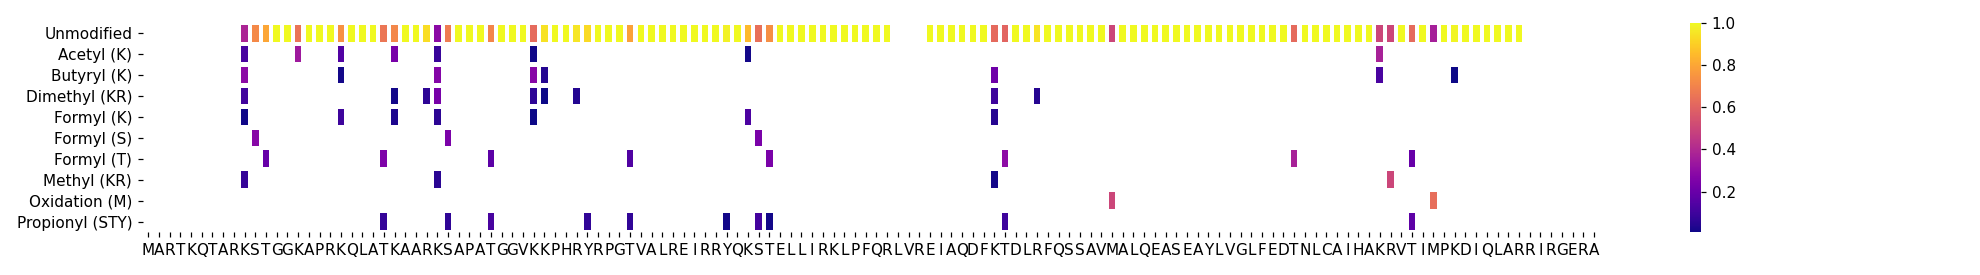

<ipython-input-1-994986bd74fd>:95: RuntimeWarning: invalid value encountered in true_divide
  data = coverage[enzyme][protein_name] / np.sum(coverage[enzyme][protein_name], axis=0)


In [4]:
%matplotlib notebook
enzyme = "PropTryp"
protein_name = "H32_BOVIN"
plotCoverage(
    coverage,
    enzyme,
    protein_name,
    protein_sequences,
    mods,
#    selection_order=['Unmodified', 'Acetyl (K)', 'Dimethyl (KR)', 'Butyryl (K)', 'Formyl (K)', 'Formyl (S)', 
#                     'Formyl (T)', 'Methyl (KR)', 'Oxidation (M)', 'Propionyl (KSTY)'],
#   plot_type="relative_spectral_abundance",
    plot_type="relative_spectral_abundance",
    linewidths=2,
    cmap = "plasma",
#     file_name="test.pdf",
    file_name=f"sandbox_data/{enzyme}_{protein_name}_autumn.svg",
#     fig_width=18,
#     fig_height=3,
)